In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import mdcalc
import re
import paper_parsing, mdcalc
import json
import sys
import numpy as np
sys.path.append('../notebooks_llm')
from eval_extraction import percentage_to_num

df_orig = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')
df_orig = mdcalc.add_feature_names(df_orig).set_index('id').drop(columns=['index'])
df_orig = mdcalc.process_categories(df_orig)
df_manual = pd.read_csv('../data/main.csv').set_index('id')
df_affil = pd.read_pickle('../data/cdis_with_author_affil.pkl')

In [35]:
# pandas merge and drop duplicates (override with manual data)
df = df_manual.merge(df_orig, on="id", how="left", suffixes=("", "_2"))
df = df[[col for col in df.columns if not col.endswith("_2")]]
# df["id"] = df.index
df = df.merge(df_affil, on="id", how="left")
df = df.drop(columns="feature_names")
df = df.rename(
    columns={
        "full_title_en": "title",
        "short_title_en": "title_short",
        "medium_description_en": "description",
        "short_description_en": "description_short",
        "disease_en": "categorization___disease",
        "specialty_en": "categorization___specialty",
        "system_en": "categorization___system",
        "purpose_en": "categorization___purpose",
        "calc_type": "categorization___type",
        "chief_complaint_en": "categorization___chief_complaint",
        "num_total_corrected": "participants___total",
        "num_male_corrected": "participants___male",
        "num_female_corrected": "participants___female",
        "num_white_corrected": "participants___white",
        "num_black_corrected": "participants___black",
        "num_asian_corrected": "participants___asian",
        "num_latino_corrected": "participants___latino",
        # info
        "instructions_en": "info___instructions",
        "search_abbreviation_en": "info___keywords",
        "before_use": "info___before_use",
        "url_full": "info___mdcalc_url",
        # paper
        "ref_href": "paper___url",
        "ref_text": "paper___citation",
        "ref_year": "paper___year",
        # paper authors
        "ref_authors_affils": "paper___author_affiliations",
        "ref_authors_countries": "paper___author_countries",
        "ref_authors_full": "paper___author_names",
        "ref_authors_genders": "paper___author_genders",
        # feature names
        "feature_names_unique": "feature_names",
        "feature_names_unique_uncleaned": "feature_names_raw",
    }
).drop(
    columns=[
        "found_paper",
        "isVisibleInListView",
        "disabled_reason",
        "disabled",
        "logic_language",
        "dosing",
        "created_at",
        "updated_at",
        "notes",
        "md5",
        "favorite_id",
        "replacement_calc_id",
        "versions",
        "versionNumber",
        "vuid",
        "input_schema",
        "publishedAt",
        "paper_contains_race_keywords",
        "tags",
        "type",
        "ref_href_corrected",
        "slug",
        # "features_names",
        "seo",
        "feature_score_tuples_list",
        "ref_original",
        "newly_added",
    ]
)
df = df.drop(
    columns=[
        k
        for k in df.columns
        if k.startswith("num_") or k.startswith("cme") or k.startswith("evidence_")
    ]
)

# get stuff out of related_calcs, refs, and content
df["info___related_cdi_ids"] = df["related_calcs"].apply(
    lambda l: [x["calcId"] for x in l]
)


def remove_primary_ref(d):
    if "Original/Primary Reference" in d:
        del d["Original/Primary Reference"]
    return d


df["info___additional_references"] = df["refs"].apply(lambda x: remove_primary_ref(x))


def remove_p_tags(s):
    s = re.sub(r"^<p>", "", s)
    s = re.sub(r"</p>$", "", s)
    return s


def remove_placeholders(s):
    if "Do you use" in s and "want to contribute your expertise?" in s:
        return ""
    return s


# content stuff
df["info___usage___use_case"] = df["content"].apply(
    lambda x: remove_placeholders(remove_p_tags(x["how_to_use"]["use_case_en"]))
)
df["info___usage___why_use"] = df["content"].apply(
    lambda x: remove_placeholders(remove_p_tags(x["how_to_use"]["why_use_en"]))
)
df["info___usage___notes"] = df["content"].apply(
    lambda x: remove_placeholders(remove_p_tags(x["how_to_use"]["pearls_pitfalls_en"]))
)
for k in ["advice", "management", "critical_actions"]:
    df[f"info___next_steps___{k}"] = df["content"].apply(
        lambda x: remove_placeholders(remove_p_tags(x["next_steps"][f"{k}_en"]))
    )
df["info___details___formula"] = df["content"].apply(
    lambda x: remove_placeholders(remove_p_tags(x["about"]["formula_en"]))
)
df["info___details___more_info"] = df["content"].apply(
    lambda x: remove_placeholders(remove_p_tags(x["about"]["more_info_en"]))
)
df["info___details___evidence_overview"] = df["content"].apply(
    lambda x: remove_placeholders(
        remove_p_tags(x["about"]["evidence_based_medicine_en"])
    )
)
df["paper___raw_text"] = df["id"].apply(
    mdcalc.try_or_none(paper_parsing.get_paper_text)
)
df = df.drop(columns=["related_calcs", "refs", "content"])
# sorted(df.columns)


# clean description
# remove any text within html tags
def remove_html_tags(text):
    clean = re.compile("<.*?>")
    return re.sub(clean, "", text)


for k in ["description", "description_short"]:
    df[k] = df[k].apply(remove_html_tags)

# convert participant numbers to integers
for k in ["participants___total", "participants___male", "participants___female"]:
    df[k] = df[k].fillna(-1).astype(int)
    if not k == "participants___total":
        assert (
            (df[k] == -1) | (df[k] <= df["participants___total"])
        ).all(), f"{k} numbers cannot exceed total"
idxs_gender_found = (df["participants___male"] != -1) & (
    df["participants___female"] != -1
)
d = df[idxs_gender_found]
# assert (
# (d["participants___male"] + d["participants___female"]) == d["participants___total"]
# ).all()
for k in [
    "participants___white",
    "participants___black",
    "participants___latino",
    "participants___asian",
]:
    df.loc[:, k] = df.loc[:, k].fillna("-1")
    idxs_perc = df[k].apply(lambda x: "%" in x)
    assert (
        idxs_perc & (df["participants___total"] == -1)
    ).sum() == 0, "if using percentage, must know total"
    df.loc[idxs_perc, k] = (
        df.loc[idxs_perc, k].apply(percentage_to_num) / 100 * df["participants___total"]
    )
    df[k] = df[k].astype(int)
    assert (
        (df[k] == -1) | (df[k] <= df["participants___total"])
    ).all(), f"{k} numbers cannot exceed total"

# add some custom fixes
df = mdcalc.rewrite_feature_names_manually(df)
df['paper___raw_text'] = df['paper___raw_text'].apply(paper_parsing.clean_paper_text)
df.to_pickle("../data/data_clean.pkl")

In [20]:
# d[(d["participants___male"] + d["participants___female"]) != d["participants___total"]][['id', 'title', 'participants___male', 'participants___female', 'participants___total']].to_csv('errs.csv')

In [34]:
# df['paper___raw_text'] = df['paper___raw_text'].apply(paper_parsing.clean_paper_text)

# # clean up raw paper texts
# df['num_unique_words'] = (
#     df["paper___raw_text"]
#     .apply(lambda x: len(set(x.split())) if isinstance(x, str) else np.nan)
#     .values
# )
# df['frac_non_ascii_chars'] = df['paper___raw_text'].apply(lambda x: sum([ord(c) > 128 for c in x]) / len(x) if isinstance(x, str) else np.nan)
# df['paper_tail'] = df['paper___raw_text'].apply(lambda x: x[-300:] if isinstance(x, str) else np.nan)
# d = df.sort_values('num_unique_words', ascending=False)
# with pd.option_context('display.max_colwidth', 500, 'display.max_rows', None):
#     display(d[['num_unique_words', 'frac_non_ascii_chars', 'paper___raw_text']].round(2))
# # for i in range(5):
#     # print('\n\n----------------------\n', d.iloc[i]['paper___raw_text'], '\n\n----------------------------\n\n')

,num_unique_words,frac_non_ascii_chars,paper___raw_text
183,16460.0,0.0,"870\nAHA/ASA Guideline\nBackground and Purpose The authors present an overview of the current evidence and management recommendations \nfor evaluation and treatment of adults with acute ischemic stroke. The intended audiences are prehospital care providers, \nphysicians, allied health professionals, and hospital administrators responsible for the care of acute ischemic stroke patients \nwithin the first 48 hours from stroke onset. These guidelines supersede the prior 2007 guidelines and 2009..."
31,11857.0,0.0,R. P. Dellinger\nMitchell M. Levy\nAndrew Rhodes\nDjillali Annane\nHerwig Gerlach\nSteven M. Opal\nJonathan E. Sevransky\nCharles L. Sprung\nIvor S. Douglas\nRoman Jaeschke\nTiffany M. Osborn\nMark E. Nunnally\nSean R. Townsend\nKonrad Reinhart\nRuth M. Kleinpell\nDerek C. Angus\nClifford S. Deutschman\nFlavia R. Machado\nGordon D. Rubenfeld\nSteven Webb\nRichard J. Beale\nJean-Louis Vincent\nRui Moreno\nThe Surviving Sepsis Campaign Guidelines Committee\nincluding The Pediatric Subgroup*\nS...
229,10579.0,0.0,The MUST Report\nTHE MUST REPORT\nNutritional screening of adults: \na multidisciplinary responsibility\nDevelopment and use of the \n Malnutrition Universal Screening Tool ( MUST ) \nfor adults \nProfessor Marinos Elia \nChairman of MAG and Editor\nAdvancing Clinical Nutrition\nReg. Charity No: 1023927\n THE MUST REPORT\nNutritional screening of adults: \na multidisciplinary responsibility\nDevelopment and use of the \n Malnutrition Universal Screening Tool ( MUST ) \nfor adults ...
126,9043.0,0.0,"Corresponding author: American Society of Clinical Oncology, 2318 Mill Rd, Ste 800, Alexandria, VA 22314; AUTHOR CONTRIBUTIONS\nManuscript writing: All authors\nFinal approval of manuscript: All authors\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nDisclosures provided by the authors are available with this article at jco.org.\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nManagement of Immune-Related Adverse Events in Patients Treated with Immune Checkpoint Inhibitor ..."
127,9043.0,0.0,"Corresponding author: American Society of Clinical Oncology, 2318 Mill Rd, Ste 800, Alexandria, VA 22314; AUTHOR CONTRIBUTIONS\nManuscript writing: All authors\nFinal approval of manuscript: All authors\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nDisclosures provided by the authors are available with this article at jco.org.\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nManagement of Immune-Related Adverse Events in Patients Treated with Immune Checkpoint Inhibitor ..."
128,9043.0,0.0,"Corresponding author: American Society of Clinical Oncology, 2318 Mill Rd, Ste 800, Alexandria, VA 22314; AUTHOR CONTRIBUTIONS\nManuscript writing: All authors\nFinal approval of manuscript: All authors\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nDisclosures provided by the authors are available with this article at jco.org.\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nManagement of Immune-Related Adverse Events in Patients Treated with Immune Checkpoint Inhibitor ..."
129,9043.0,0.0,"Corresponding author: American Society of Clinical Oncology, 2318 Mill Rd, Ste 800, Alexandria, VA 22314; AUTHOR CONTRIBUTIONS\nManuscript writing: All authors\nFinal approval of manuscript: All authors\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nDisclosures provided by the authors are available with this article at jco.org.\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nManagement of Immune-Related Adverse Events in Patients Treated with Immune Checkpoint Inhibitor ..."
130,9043.0,0.0,"Corresponding author: American Society of Clinical Oncology, 2318 Mill Rd, Ste 800, Alexandria, VA 22314; AUTHOR CONTRIBUTIONS\nManuscript writing: All authors\nFinal approval of manuscript: All authors\nAUTHORS DISCLOSURES OF POTENTIAL CONFLICTS OF INTEREST\nDisclosures provided by the authors are available with this article at

In [12]:
d[['num_unique_words', 'frac_non_ascii_chars', 'paper___raw_text']].loc[[302, 209, 180]]['paper___raw_text']

302    CLINICAL RESEARCH\nAtrial  brillation\nThe ORB...
209    Translating the A1C Assay Into Estimated\nAver...
180    CLINICAL RESEARCH\nChronic heart failure\nPred...
Name: paper___raw_text, dtype: object

597


<Axes: >

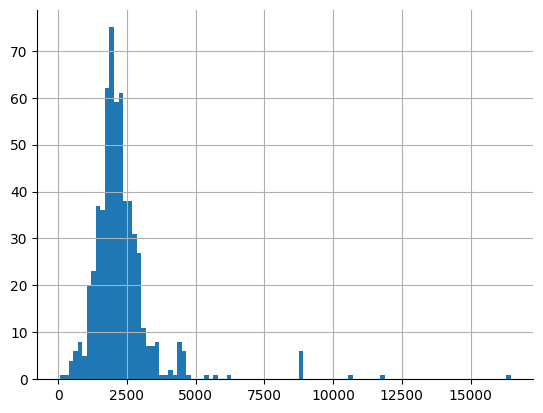

In [14]:
print(df['paper___raw_text'].notna().sum())
df['num_unique_words'].hist(bins=100)

# Write documentation

In [ ]:
docs = {
    "id": "Unique identifier of the CDI",
    "title": "Title of the CDI",
    "title_short": "Short title of the CDI",
    "description": "Description of the CDI",
    "description_short": "Short description of the CDI",
    # feature names
    "feature_names": "Names of the features of the CDI",
    "feature_names_raw": "Names of the features of the CDI (before manual cleaning)",
    # categorizations
    "categorization___chief_complaint": "Chief complaint this CDI addresses",
    "categorization___disease": "Disease this CDI addresses",
    "categorization___purpose": "Purpose of this CDI",
    "categorization___type": "Type of this CDI",
    "categorization___specialty": "Specialty this CDI addresses",
    "categorization___system": "System this CDI addresses",
    # paper stuff
    "paper___raw_text": "Raw text of the paper extracted from the pdf",
    "paper___url": "Pubmed link to the paper",
    "paper___citation": "Citation of the paper (authors + title + journal + year)",
    "paper___author_names": "Names of the authors of the paper",
    "paper___author_affiliations": "Affiliations of the authors of the paper",
    "paper___year": "Year of the paper's publication",
    # extracted stuff
    "participants___total": "Total number of participants",
    "participants___male": "Number of participants identified as male",
    "participants___female": "Number of participants identified as female",
    "participants___white": "Number of participants self-identified as white",
    "participants___black": "Number of participants self-identified as black",
    "participants___asian": "Number of participants self-identified as asian",
    "participants___latino": "Number of participants self-identified as latino",
    # info
    "info___related_cdi_ids": "Unique IDs of the related CDIs",
}
for k in docs:
    assert k in df.columns
json.dump(docs, open("../data/data_clean_dictionary.json", "w"), indent=2)

In [ ]:
cols_nice_order = [k for k in df.columns if not k.startswith('info')] + [k for k in df.columns if k.startswith('info')]
df[cols_nice_order].drop(columns='paper___raw_text').to_csv('data.csv')